In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

##ONNX 파일로 변환

In [ ]:
# 오픈 소스 도구 다운로드

%cd /content
!git clone https://github.com/Tianxiaomo/pytorch-YOLOv4.git
%cd pytorch-YOLOv4

In [ ]:
# 필요한 파일 복사(cfg, weights)
!cp /content/drive/MyDrive/Test/backup/custom-train-yolo4.cfg .
!cp /content/drive/MyDrive/Test/backup/custom-train-yolo4_final.weights .

현재 디렉토리(pytorch-YOLOv4)에 export_onnx.py 업로드

In [ ]:
import shutil
import os

drive_base = "/content/drive/MyDrive/Test/backup"
target_base = "/content/custom"

os.makedirs(target_base, exist_ok=True)

# 복사 대상
files_to_copy = [
    "custom-train-yolo4.cfg",
    "custom-train-yolo4_final.weights",
    "classes.names",
    "20250601_201307.jpg"  # 없다면 생략 가능
]

for filename in files_to_copy:
    src = os.path.join(drive_base, filename)
    dst = os.path.join(target_base, filename)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"✅ 복사 완료: {filename}")
    else:
        print(f"⚠ 파일 없음 (건너뜀): {filename}")


✅ 복사 완료: custom-train-yolo4.cfg
✅ 복사 완료: custom-train-yolo4_final.weights
✅ 복사 완료: classes.names
✅ 복사 완료: 20250601_201307.jpg


In [ ]:
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
!python3 demo_darknet2onnx.py \
  /content/custom/custom-train-yolo4.cfg \
  /content/custom/classes.names \
  /content/custom/custom-train-yolo4_final.weights \
  /content/custom/test_image.jpg \
  1

In [ ]:
# ONNX 유효성 확인
import onnx

onnx_model = onnx.load("custom-train-yolo4_final.onnx")
onnx.checker.check_model(onnx_model)
print("✅ 변환된 ONNX 모델이 정상입니다.")

In [ ]:
import os

for f in os.listdir():
    if f.endswith(".onnx"):
        print(f)


yolov4_1_3_416_416_static.onnx


In [ ]:
import onnx

onnx_model = onnx.load("yolov4_1_3_416_416_static.onnx")
onnx.checker.check_model(onnx_model)
print("✅ 변환된 ONNX 모델이 정상입니다.")


✅ 변환된 ONNX 모델이 정상입니다.


In [ ]:
import onnx

model = onnx.load("yolov4_1_3_416_416_static.onnx")
output_names = [output.name for output in model.graph.output]
print("🔍 출력 노드 이름:", output_names)


🔍 출력 노드 이름: ['boxes', 'confs']


In [ ]:
!cp /content/drive/MyDrive/Test/backup/classes.names /content/custom/classes.names

In [ ]:
import cv2
import numpy as np
import onnxruntime
from tool.utils import post_processing, load_class_names, plot_boxes_cv2

# 모델 로딩
onnx_path = 'yolov4_1_3_416_416_static.onnx'
session = onnxruntime.InferenceSession(onnx_path)

# 입력 이미지 전처리
image_path = '/content/drive/MyDrive/Test/backup/20250601_201313.jpg'
image_src = cv2.imread(image_path)
input_shape = session.get_inputs()[0].shape  # [1, 3, 416, 416]
IN_IMAGE_H, IN_IMAGE_W = input_shape[2], input_shape[3]

resized = cv2.resize(image_src, (IN_IMAGE_W, IN_IMAGE_H), interpolation=cv2.INTER_LINEAR)
img_in = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
img_in = np.transpose(img_in, (2, 0, 1)).astype(np.float32)
img_in = np.expand_dims(img_in, axis=0)
img_in /= 255.0

# 추론
input_name = session.get_inputs()[0].name
boxes_output, confs_output = session.run(None, {input_name: img_in})

# 후처리
boxes = post_processing(img_in, 0.4, 0.6, (boxes_output, confs_output))

# 클래스 이름 로딩
class_names = load_class_names("/content/custom/classes.names")

# 결과 시각화
plot_boxes_cv2(image_src, boxes[0], savename='predictions_onnx.jpg', class_names=class_names)


##TensorRT 파일로 변환

In [ ]:
import cv2
import numpy as np
import onnxruntime

# 이미지 경로
image_path = '/content/drive/MyDrive/Test/backup/20250601_201307.jpg'
image_src = cv2.imread(image_path)

# === ✅ 전처리 ===
resized = cv2.resize(image_src, (416, 416), interpolation=cv2.INTER_LINEAR)
img_in = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
img_in = np.transpose(img_in, (2, 0, 1)).astype(np.float32)
img_in = np.expand_dims(img_in, axis=0)
img_in /= 255.0  # 정규화


# === ✅ ONNX 추론 ===
onnx_path = "/content/pytorch-YOLOv4/yolov4_1_3_416_416_static.onnx"
session = onnxruntime.InferenceSession(onnx_path)
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_in})
boxes_output, confs_output = outputs

# === ✅ 후처리 ===
from tool.utils import post_processing, load_class_names, plot_boxes_cv2

boxes = post_processing(img_in, 0.3, 0.45, [boxes_output, confs_output])
class_names = load_class_names("/content/custom/classes.names")

# === ✅ 시각화 ===
plot_boxes_cv2(image_src, boxes[0], savename='predictions_onnx.jpg', class_names=class_names)

from IPython.display import Image, display

display(Image(filename="predictions_onnx.jpg"))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 원본 이미지 크기
orig_h, orig_w = image_src.shape[:2]

# 후처리에서 얻은 boxes[0] 안의 좌표값은 416 기준임 → 원본으로 다시 맞춰줘야 함
scaled_boxes = []
for box in boxes[0]:
    x1 = int(box[0] * orig_w / 416)
    y1 = int(box[1] * orig_h / 416)
    x2 = int(box[2] * orig_w / 416)
    y2 = int(box[3] * orig_h / 416)
    cls_conf = box[4]
    cls_id = box[5]
    scaled_boxes.append([x1, y1, x2, y2, cls_conf, cls_id])

# numpy array로 변환
scaled_boxes = np.array(scaled_boxes)

# 시각화
plot_boxes_cv2(image_src, scaled_boxes, savename='predictions_onnx.jpg', class_names=class_names)


save plot results to predictions_onnx.jpg


array([[[ 98,  96,  86],
        [ 91,  89,  79],
        [ 90,  88,  78],
        ...,
        [136, 139, 137],
        [133, 136, 134],
        [131, 134, 132]],

       [[ 97,  95,  85],
        [ 93,  91,  81],
        [ 92,  90,  80],
        ...,
        [136, 139, 137],
        [132, 135, 133],
        [136, 139, 137]],

       [[101,  99,  89],
        [ 99,  97,  87],
        [ 96,  94,  84],
        ...,
        [133, 136, 134],
        [133, 136, 134],
        [145, 148, 146]],

       ...,

       [[132, 162, 173],
        [131, 161, 172],
        [130, 160, 171],
        ...,
        [188, 187, 191],
        [189, 188, 192],
        [188, 187, 191]],

       [[131, 161, 172],
        [130, 160, 171],
        [130, 160, 171],
        ...,
        [188, 187, 191],
        [187, 186, 190],
        [185, 184, 188]],

       [[128, 158, 169],
        [128, 158, 169],
        [129, 159, 170],
        ...,
        [188, 187, 191],
        [187, 186, 190],
        [187, 186, 190]]

PostIt: 0.542371
save plot results to predictions_onnx.jpg


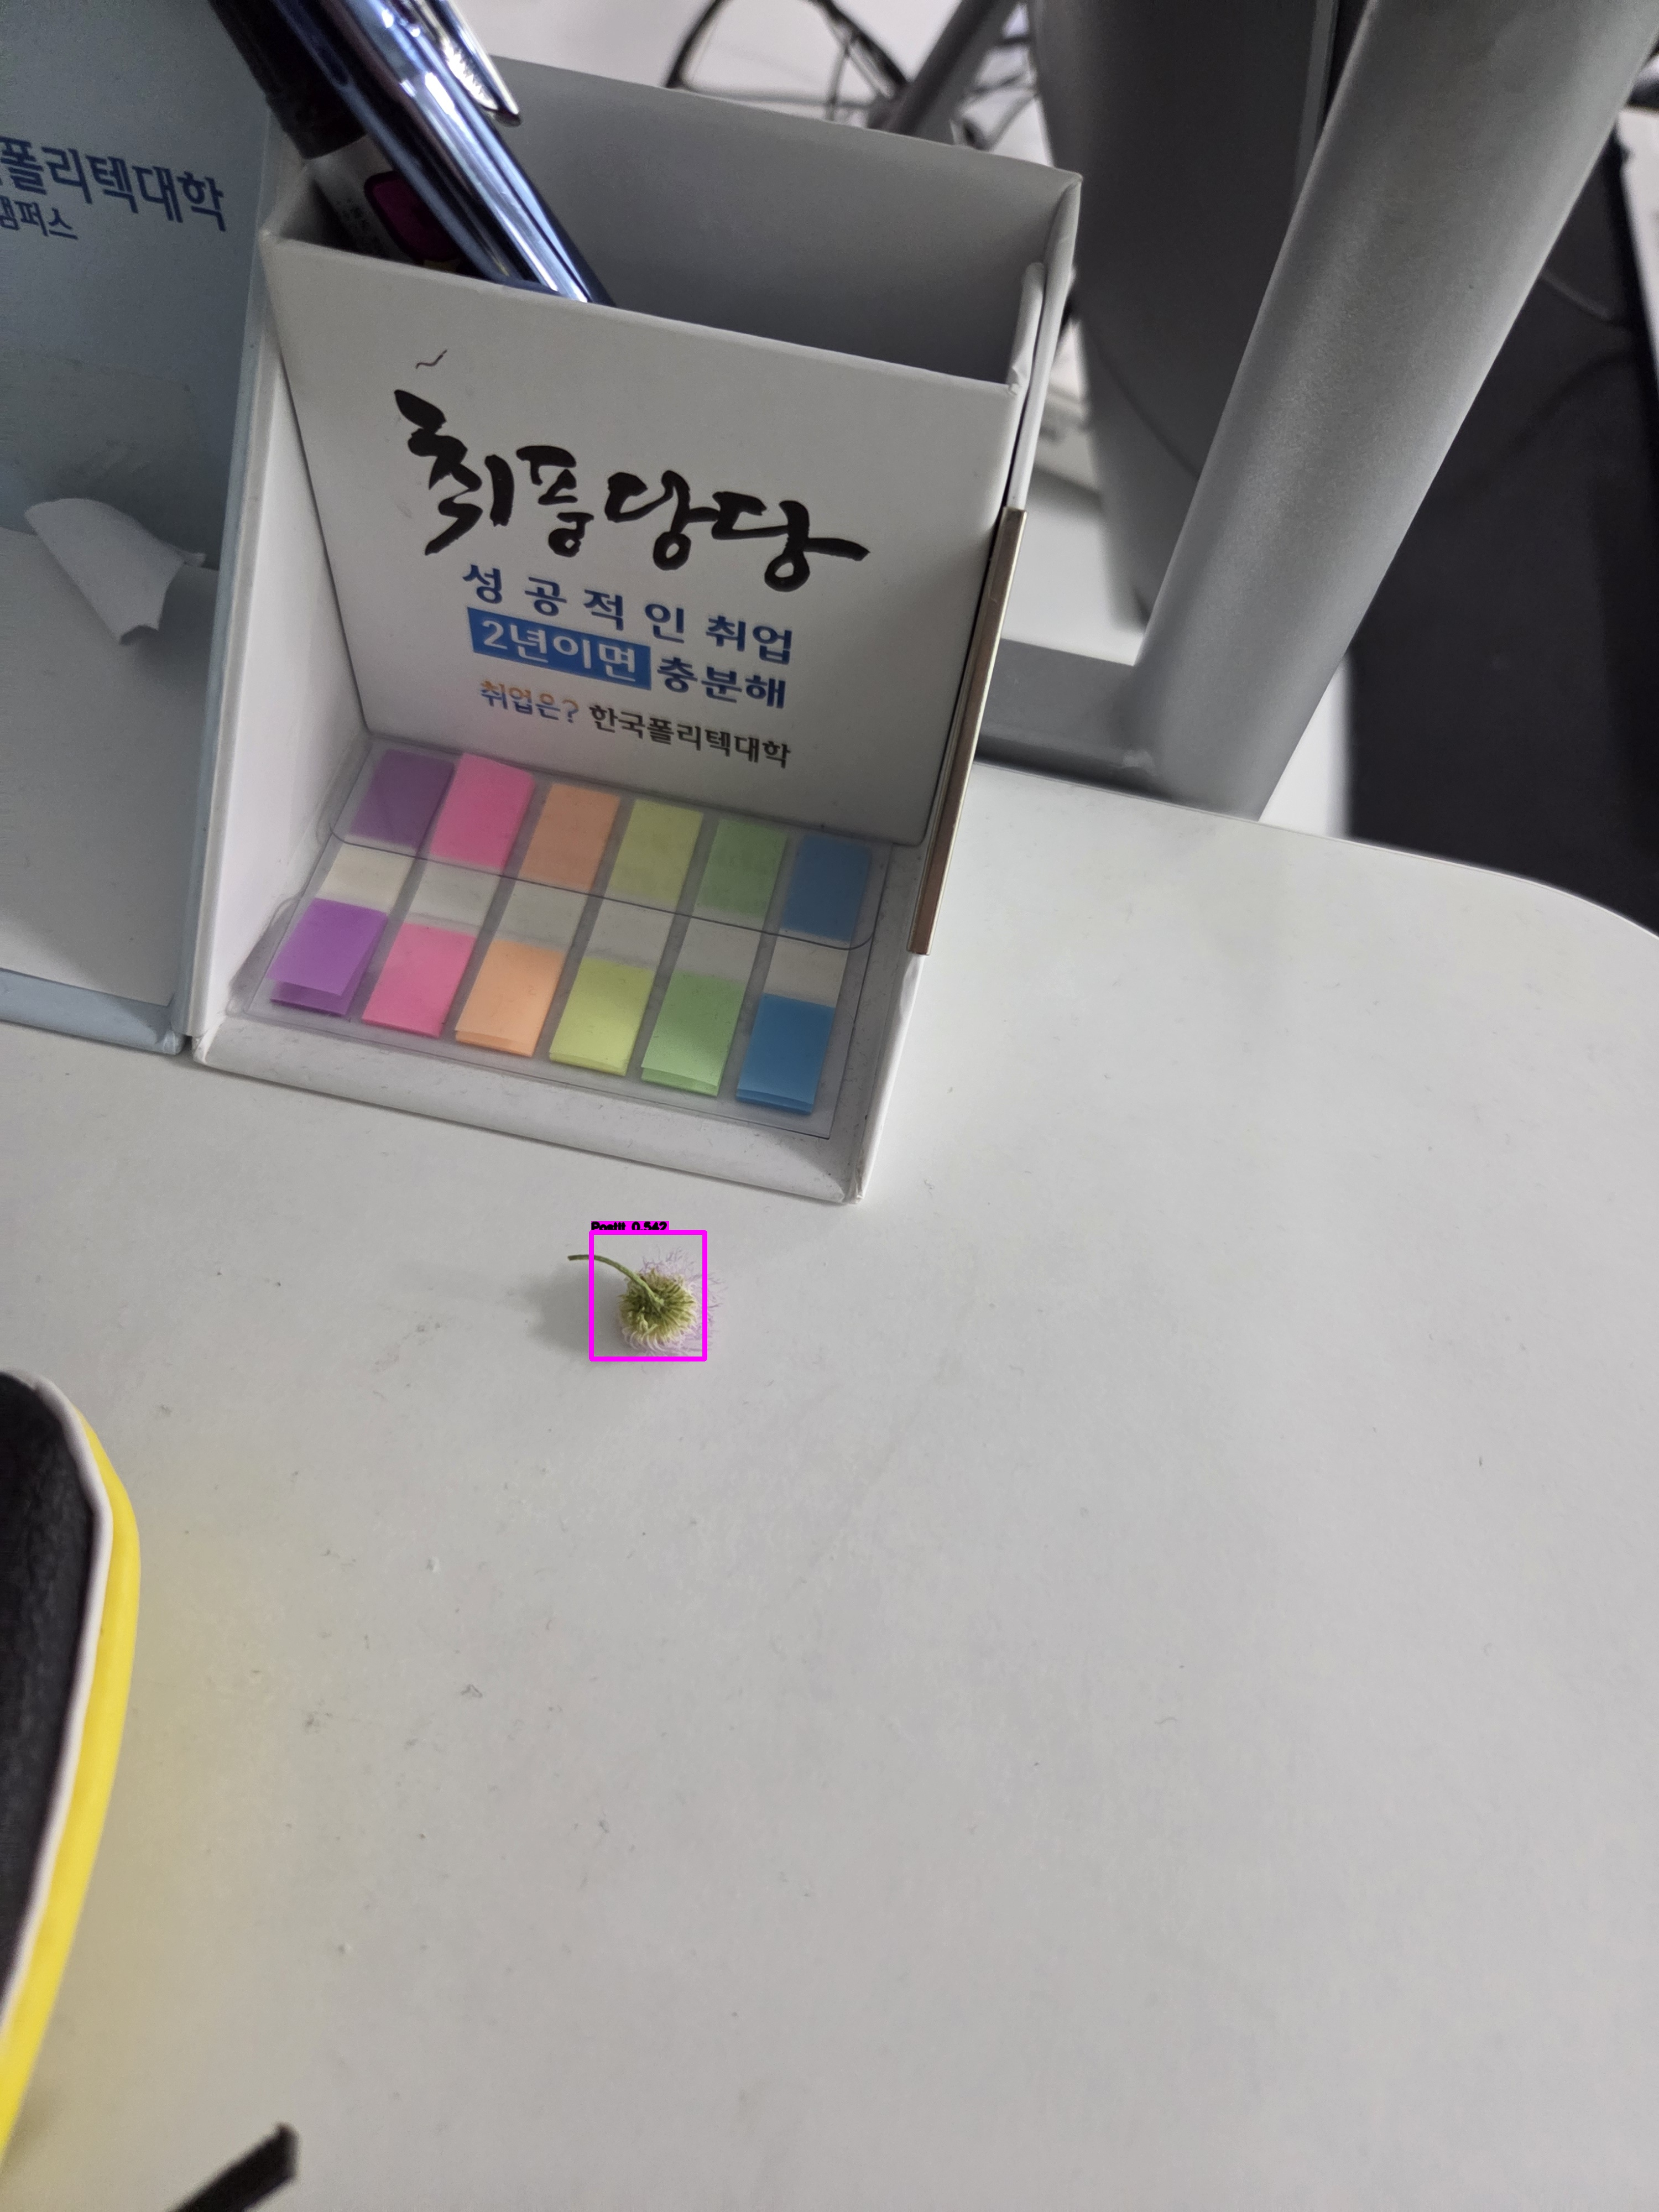

In [ ]:
# === ✅ 시각화 ===
plot_boxes_cv2(image_src, boxes[0], savename='predictions_onnx.jpg', class_names=class_names)

from IPython.display import Image, display

display(Image(filename="predictions_onnx.jpg"))

In [ ]:
# trtexec 설치 확인
# ONNX 파일만 Colab에서 만든 뒤,→ .onnx 파일을 본인의 Jetson 보드에서 아래 명령으로 변환

In [ ]:
trtexec --onnx=custom-train-yolo4_final.onnx --saveEngine=custom-train-yolo4_final.trt --explicitBatch